In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\hp\Desktop\Datas\powerconsumption.csv")  # replace with your CSV path
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [4]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month

In [5]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 
            'DiffuseFlows', 'hour', 'day', 'weekday', 'month']
targets = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']


In [16]:
# Create lag features (previous consumption values)
lag_steps = [1, 2, 3]
roll_windows = [3, 6, 12]

for zone in targets:
    for lag in lag_steps:
        df[f'{zone}_lag{lag}'] = df[zone].shift(lag)
    for window in roll_windows:
        df[f'{zone}_roll{window}'] = df[zone].shift(1).rolling(window=window).mean()

# Drop rows with NaN created by lag/rolling
df.dropna(inplace=True)

# Update features list
features = [col for col in df.columns if col not in targets]


In [17]:
train_size = int(len(df)*0.8)
X_train = df[features].iloc[:train_size]
X_test = df[features].iloc[train_size:]


In [18]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

results = {}
for zone in targets:
    y_train = df[zone].iloc[:train_size]
    y_test = df[zone].iloc[train_size:]
    

In [22]:
param_grid = {
        'n_estimators': [200, 500, 700],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 1],
        'colsample_bytree': [0.7, 0.8, 1]
    }
    
xgb = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=10,
        cv=tscv,
        scoring='r2',
        n_jobs=-1
    )
    
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
    
results[zone] = {'model': best_model, 'y_pred': y_pred}
    

In [29]:
print(results.keys())


dict_keys(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'])


In [27]:
for zone in targets:
    print(zone, df[zone].isna().sum())


PowerConsumption_Zone1 0
PowerConsumption_Zone2 0
PowerConsumption_Zone3 0


In [28]:
results = {}
for zone in targets:
    try:
        y_train = df[zone].iloc[:train_size]
        y_test = df[zone].iloc[train_size:]
        
        # Your RandomizedSearchCV / XGB model training here
        xgb = XGBRegressor(random_state=42)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        results[zone] = {'model': xgb, 'y_pred': y_pred}
        print(f"{zone} trained successfully!")
        
    except Exception as e:
        print(f"Training failed for {zone}: {e}")


PowerConsumption_Zone1 trained successfully!
PowerConsumption_Zone2 trained successfully!
PowerConsumption_Zone3 trained successfully!


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

for zone in ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']:
    y_test = df[zone].iloc[train_size:]          # actual values
    y_pred = results[zone]['y_pred']            # predicted values
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"---{zone}---")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}\n")


---PowerConsumption_Zone1---
MSE: 500532.27
RMSE: 707.48
MAE: 529.77
R2: 0.99

---PowerConsumption_Zone2---
MSE: 200836.13
RMSE: 448.15
MAE: 308.75
R2: 0.99

---PowerConsumption_Zone3---
MSE: 289516.21
RMSE: 538.07
MAE: 369.28
R2: 0.97



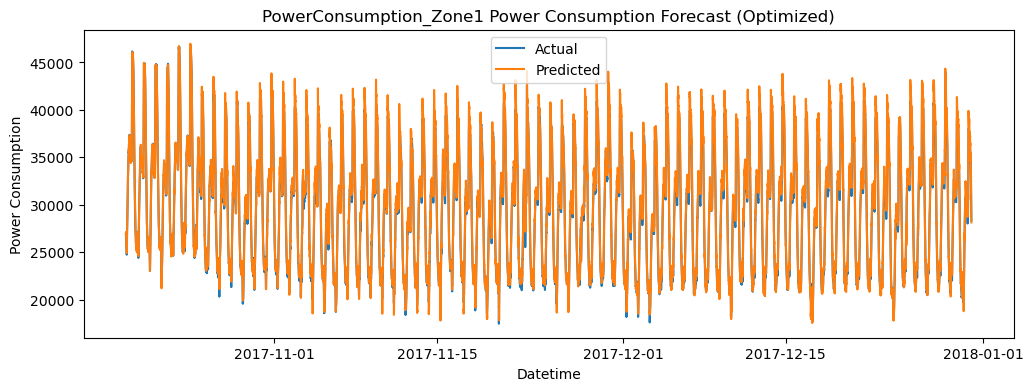

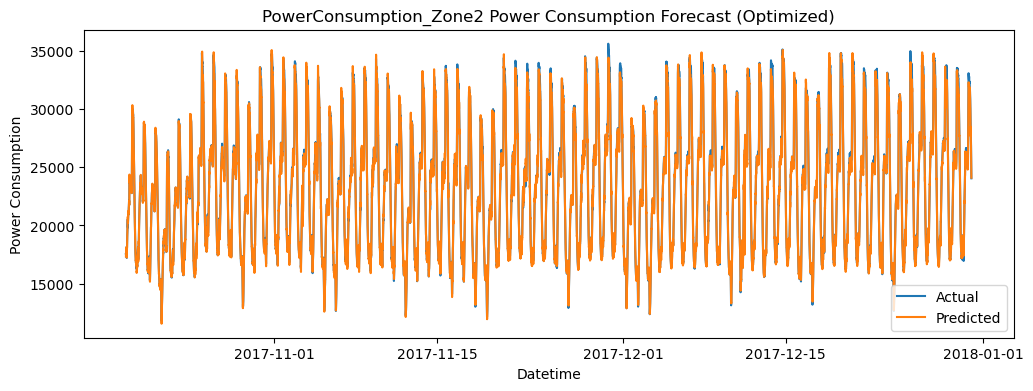

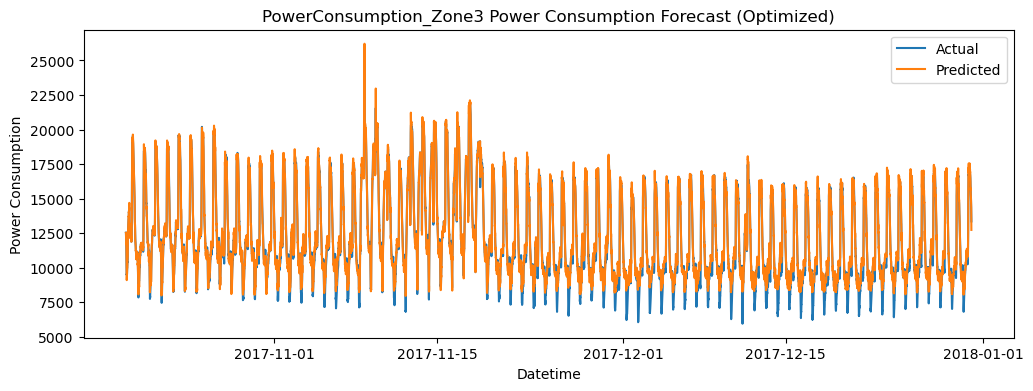

In [32]:
for zone in targets:
    y_test = df[zone].iloc[train_size:]
    y_pred = results[zone]['y_pred']
    
    plt.figure(figsize=(12,4))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{zone} Power Consumption Forecast (Optimized)')
    plt.xlabel('Datetime')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()



In [38]:
# Number of future steps to forecast
N = 10  

# Copy the last row of known data to start forecasting
last_row = df[features].iloc[-1].copy()  # includes lag + rolling + time features
future_predictions = []

for i in range(N):
    step_pred = {}
    
    for zone in targets:
        model = results[zone]['model']
        # Predict next step
        step_pred[zone] = model.predict(last_row.values.reshape(1, -1))[0]
    
    future_predictions.append(step_pred)
    
    # Update last_row for next iteration
    # 1️⃣ Shift lag features: lag1 = predicted, lag2 = previous lag1, lag3 = previous lag2
    for zone in targets:
        last_row[f'{zone}_lag3'] = last_row[f'{zone}_lag2']
        last_row[f'{zone}_lag2'] = last_row[f'{zone}_lag1']
        last_row[f'{zone}_lag1'] = step_pred[zone]
    
    # 2️⃣ Update rolling features (simple approach: append predicted value and compute rolling mean)
    for zone in targets:
        for window in [3, 6, 12]:
            # approximate rolling mean using last value
            last_row[f'{zone}_roll{window}'] = last_row[f'{zone}_roll{window}'] * (window-1)/window + step_pred[zone]/window
    
    # 3️⃣ Update time features
    last_row['hour'] = (last_row['hour'] + 1) % 24
    if last_row['hour'] == 0:
        last_row['day'] += 1
        last_row['weekday'] = (last_row['weekday'] + 1) % 7
        # Optionally handle month/year increment if needed

# Convert predictions to DataFrame
future_df = pd.DataFrame(future_predictions)
print("Next N-step Forecast:")
print(future_df)



Next N-step Forecast:
   PowerConsumption_Zone1  PowerConsumption_Zone2  PowerConsumption_Zone3
0            28151.285156            24104.050781            12729.400391
1            27968.001953            22965.068359            12153.263672
2            27820.654297            22679.406250            11624.663086
3            27744.583984            22398.642578            11286.767578
4            27426.169922            22770.742188            11159.637695
5            26720.347656            22939.246094            11031.194336
6            26133.800781            22853.185547            10497.052734
7            25762.509766            22690.605469             9735.533203
8            25707.460938            22511.388672             9469.811523
9            26290.388672            22603.583984             9534.472656
